In [28]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from tqdm import tqdm

In [29]:
# from google.colab import drive
# drive.mount('/content/drive')

In [30]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cpu


#### Hyper-parameters

In [31]:
DS = datasets.MNIST # MNIST, CIFAR10

N_BATCH = 32 # mini-batch size
MODEL_NAME = 'CNN_deep' # MLP, CNN, CNN_deep
# LR = 1e-1
# LR = 1e-2
LR = 1e-3
EPOCH = 5

TRAIN_MODEL = True               # 새로 학습할지 여부
SAVE_MODEL = True and TRAIN_MODEL # 학습한 경우, 모델을 파일에 저장할지 여부
LOAD_MODEL = not TRAIN_MODEL      # 테스트를 위해 저장된 모델을 사용할지 여부(True: 저장된 모델, False: 학습한 모델)

DATA_PATH = '../data' # where to save data
MODEL_PATH = '../result' # where to save model

## STEP 1. DATA set

#### Dataset

In [32]:
DS_NAME = DS.__name__
print(DS_NAME)

MNIST


In [33]:
transform = transforms.ToTensor()
train_DS = DS(root=DATA_PATH, train=True, download=True, transform=transform)
test_DS = DS(root=DATA_PATH, train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:11<00:00, 890kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 98.0kB/s]
100%|██████████| 1.65M/1.65M [00:05<00:00, 299kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 18.6MB/s]


In [34]:
print(train_DS)
print(test_DS)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: ToTensor()


Number of classes : 10
Classes : ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Class-to-index map : {'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}


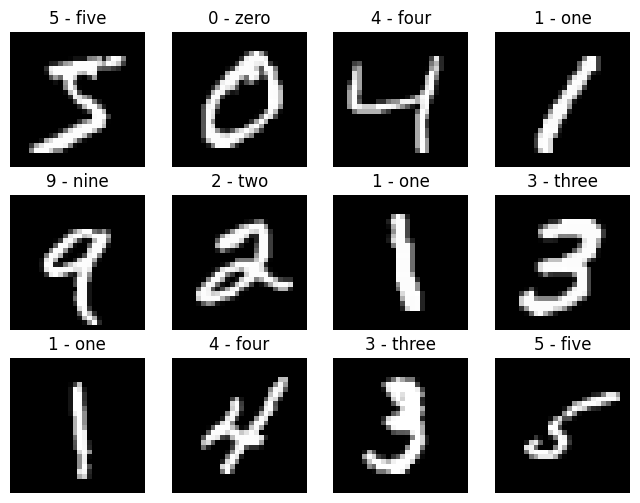

In [35]:
print(f'Number of classes : {len(train_DS.classes)}')
print(f'Classes : {train_DS.classes}')
print(f'Class-to-index map : {train_DS.class_to_idx}')
plt.figure(figsize=(8, 6))
for i in range(12):
  plt.subplot(3, 4, i+1)
  # plt.subplot(3, 4, i+1, xticks=[], yticks=[])
  plt.imshow(train_DS.data[i], cmap='gray')
  plt.title(train_DS.classes[train_DS.targets[i]], color='k')
  plt.axis('off')

#### Dataloader

In [36]:
train_DL = torch.utils.data.DataLoader(train_DS, batch_size=N_BATCH, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=N_BATCH, shuffle=False)

#### Get data parameters

In [37]:
N_TRAIN = len(train_DS)
N_TEST = len(test_DS)
print(f'Number of training data : {N_TRAIN}')
print(f'Number of test data : {N_TEST}')

N_CLASSES = len(train_DS.classes)
print(f'Number of classes: {N_CLASSES}')

x_batch, y_batch = next(iter(train_DL))
N_CH = x_batch.shape[1]
N_WIDTH = x_batch.shape[2]
N_HEIGHT = x_batch.shape[3]
print(f'Channel: {N_CH}, Width: {N_WIDTH}, Height: {N_HEIGHT}')

Number of training data : 60000
Number of test data : 10000
Number of classes: 10
Channel: 1, Width: 28, Height: 28


<class 'torch.Tensor'>
torch.Size([32, 1, 28, 28])
torch.Size([32])
torch.float32


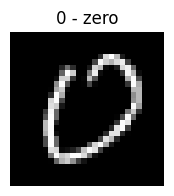

In [38]:
# torch.dataset.transforms.ToTensor()의 역할
#   1.tensor로 변환
#   2. shape을 '개채행렬'로 변환
#   3. int[0,255]->float[0.0,1.0]로 변환

x_batch, y_batch = next(iter(train_DL))
print(type(x_batch))
print(x_batch.shape)
print(y_batch.shape)
print(x_batch.dtype)

plt.figure(figsize=(2,2))
if N_CH == 1:
  plt.imshow(x_batch[0].squeeze(), cmap='gray')
else:
  plt.imshow(x_batch[0].squeeze().permute(1, 2, 0))
plt.title(train_DS.classes[y_batch[0]], color='k')
plt.axis('off')
plt.show()

## STEP 2. 모델

#### MLP

In [39]:
class MLP(nn.Module):
  def __init__(self, channel, width, height, classes):
    super().__init__()

    self.fcs = nn.Sequential(nn.Linear(channel * width * height, 100),
                             nn.ReLU(),
                             nn.Linear(100, classes))

  def forward(self, x):
    x = x.view(x.shape[0], -1) #
    # x = x.flatten(dim=1) # batch size 만 남기고 flatten()
    x = self.fcs(x)
    return x

In [40]:
class MLP_shallow(nn.Module):
  def __init__(self, channel, width, height, classes):
    super().__init__()

    self.fcs = nn.Sequential(nn.Linear(channel * width * height, 100),
                             nn.BatchNormal1d(100),
                             nn.ReLU(),
                             nn.Linear(100, classes))

  def forward(self, x):
    x = x.view(x.shape[0], -1) #
    # x = x.flatten(dim=1) # batch size 만 남기고 flatten()
    x = self.fcs(x)
    return x

In [41]:
class MLP_deep(nn.Module):
  def __init__(self, channel, width, height, classes):
    super().__init__()

    self.fcs = nn.Sequential(nn.Linear(channel * width * height, 75),
                             nn.BatchNormal1d(75),
                             nn.ReLU(),
                             *[i for _ in range(13) for i in [nn.Linear(75, 75), nn.ReLU()]],
                             nn.Linear(75, classes))

  def forward(self, x):
    x = x.view(x.shape[0], -1) #
    # x = x.flatten(dim=1) # batch size 만 남기고 flatten()
    x = self.fcs(x)
    return x

#### CNN

In [42]:
class CNN(nn.Module):
  def __init__(self, channel, width, height, classes):
    super().__init__()

    self.conv1 = nn.Sequential(nn.Conv2d(channel, 10, 3, padding=1),
                               nn.BatchNorm2d(10),
                               nn.ReLU())
    self.maxpool1 = nn.MaxPool2d(2); width //= 2; height //= 2
    self.conv2 = nn.Sequential(nn.Conv2d(10, 20, 3, padding=1),
                               nn.BatchNorm2d(20),
                               nn.ReLU())
    self.maxpool2 = nn.MaxPool2d(2); width //= 2; height //= 2
    self.conv3 = nn.Sequential(nn.Conv2d(20, 40, 3, padding=1),
                               nn.BatchNorm2d(40),
                               nn.ReLU())
    self.maxpool3 = nn.MaxPool2d(2); width //= 2; height //= 2
    self.fc1 = nn.Linear(40*width*height, 100)
    self.fc2 = nn.Linear(100, classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.maxpool1(x)
    x = self.conv2(x)
    x = self.maxpool2(x)
    x = self.conv3(x)
    x = self.maxpool3(x)
    x = x.view(x.shape[0], -1) # (batch size, ) 의 2차원 tensor로 변환
    # x = x.flatten(dim=1) # batch size 만 남기고 flatten()
    x = self.fc1(x)
    x = self.fc2(x)
    return x

In [43]:
class CNN_deep(nn.Module):
  def __init__(self, channel, width, height, classes):
    super().__init__()

    self.conv1 = nn.Sequential(nn.Conv2d(channel, 32, 3, padding=1),
                               nn.BatchNorm2d(32),
                               nn.ReLU(),
                               nn.Conv2d(32, 32, 3, padding=1),
                               nn.BatchNorm2d(32),
                               nn.ReLU())
    self.maxpool1 = nn.MaxPool2d(2); width //= 2; height //= 2
    self.conv2 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1),
                               nn.BatchNorm2d(64),
                               nn.ReLU(),
                               nn.Conv2d(64, 64, 3, padding=1),
                               nn.BatchNorm2d(64),
                               nn.ReLU())
    self.maxpool2 = nn.MaxPool2d(2); width //= 2; height //= 2
    self.conv3 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1),
                               nn.BatchNorm2d(128),
                               nn.ReLU(),
                               nn.Conv2d(128, 128, 3, padding=1),
                               nn.BatchNorm2d(128),
                               nn.ReLU())
    self.maxpool3 = nn.MaxPool2d(2); width //= 2; height //= 2
    self.fc = nn.Sequential(nn.Linear(128*width*height, 512),
                            nn.Linear(512, classes))

  def forward(self, x):
    x = self.conv1(x)
    x = self.maxpool1(x)
    x = self.conv2(x)
    x = self.maxpool2(x)
    x = self.conv3(x)
    x = self.maxpool3(x)
    x = x.view(x.shape[0], -1) # (batch size, ) 의 2차원 tensor로 변환
    # x = x.flatten(dim=1) # batch size 만 남기고 flatten()
    x = self.fc(x)
    return x

#### 모델 생성

In [44]:
model = globals()[MODEL_NAME](N_CH, N_WIDTH, N_HEIGHT, N_CLASSES).to(DEVICE)
print(model)
x_batch, y_batch = next(iter(train_DL))
x_batch = x_batch.to(DEVICE)
y_batch = y_batch.to(DEVICE)
print(x_batch.shape)
print(y_batch.shape)
y = model(x_batch.to(DEVICE))
print(y.shape, y[0])
print(y_batch.shape, y_batch[0])

CNN_deep(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(

In [45]:
# loss function test
print(y.shape)
print(y_batch.shape)
print('-'*30)

# METHOD 1. torch.nn.CrossEntropyLoss() (softmax 내장)
criterion = nn.CrossEntropyLoss() # Binary Cross Entropy loss
loss = criterion(y, y_batch.to(DEVICE))
print(loss)

# METHOD 2. torch.functional.cross_entropy (softmax 내장)
from torch.functional import F
loss = F.cross_entropy(y, y_batch.to(DEVICE))
print(loss)

# METHOD 3. torch.nn.Softmax() 후 직접 계산
softmax = nn.Softmax(dim=1)
y_soft = softmax(y)
# print(y_soft)
loss = 0
for i, val in enumerate(y_soft):
  loss += -torch.log(val[y_batch[i]]) # 정답에 대한 확률에 마이너스 로그 취한 값
loss /= len(y_batch)
print(loss)

torch.Size([32, 10])
torch.Size([32])
------------------------------
tensor(2.3480, grad_fn=<NllLossBackward0>)
tensor(2.3480, grad_fn=<NllLossBackward0>)
tensor(2.3480, grad_fn=<DivBackward0>)


#### 모델 파라미터 개수 출력

In [46]:
# parameter 수 구하기
def count_params(model):
  return sum([p.numel() for p in model.parameters()])

print(f'number of parameters : {count_params(model)}')

number of parameters : 882794


## STEP 3. 모델 훈련

#### mini-batch SGD (Stochastic Gradient Descent)

In [47]:
if TRAIN_MODEL:
  # optimizer = optim.SGD(model.parameters(), lr=LR)
  optimizer = optim.Adam(model.parameters(), lr=LR)

  criterion = nn.CrossEntropyLoss() # Binary Cross Entropy loss

  L_hist = [] # loss history
  grad_hist = [] # gradient history
  progressbar = tqdm(total=N_TRAIN*EPOCH)
  data_processed = 0

  model.train() # train mode로 설정
  for epoch in range(EPOCH):

    rloss = 0 # running loss

    for x_batch, y_batch in train_DL:
      x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
      # print(x_batch.shape, y_batch.shape)

      # 1. inference
      y_hat = model(x_batch)
      # print(y_hat.shape)

      # 2. loss
      loss = criterion(y_hat, y_batch) # loss
      rloss += (loss.item() * x_batch.size(0))

      # 3. gradient
      optimizer.zero_grad() # optimizer
      loss.backward()
      # grad_hist.append(torch.sum(torch.abs(model.linear[0].weight.grad)).item())

      # 4. update weights
      optimizer.step()

      data_processed += x_batch.size(0)
      if data_processed > (N_TRAIN//10):
        progressbar.update(data_processed)
        progressbar.set_description(f'Epoch: {epoch+1}/{EPOCH}, Loss: {loss:.4f}')
        data_processed = 0

    rloss /= N_TRAIN
    L_hist.append(rloss)
    # print(f'Epoch: {epoch+1}, Loss: {rloss}')

    if data_processed > 0:
      progressbar.update(data_processed)
      progressbar.set_description(f'Epoch: {epoch+1}/{EPOCH}, Loss: {loss:.4f}')
      data_processed = 0

  L_hist_str = [f'{l:.5f}' for l in L_hist]
  print()
  print(L_hist_str)
  # print(grad_hist)

Epoch: 5/5, Loss: 0.6626: 100%|██████████| 250000/250000 [02:16<00:00, 1830.29it/s]



['0.11353', '0.04336', '0.03421', '0.02840', '0.02305']


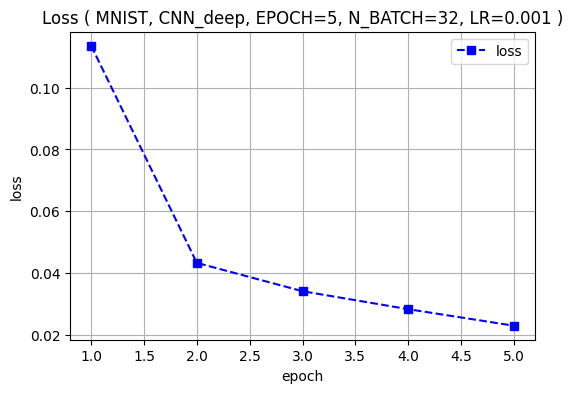

In [48]:
if TRAIN_MODEL:
  plt.figure(figsize=(6,4))
  plt.title(f'Loss ( {DS_NAME}, {MODEL_NAME}, EPOCH={EPOCH}, N_BATCH={N_BATCH}, LR={LR} )')
  # plt.subplot(1, 2, 1)
  plt.plot([i+1 for i in range(EPOCH)], L_hist, 'bs--', label='loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.grid()
  # plt.subplot(1, 2, 2)
  # # plt.plot([i+1 for i in range(EPOCH)], grad_hist, 'go--', label='gradient')
  # plt.xlabel('epoch')
  # plt.ylabel('gradient')
  # plt.legend()
  # plt.grid()

### 모델 저장 / 로드

In [49]:
if TRAIN_MODEL and SAVE_MODEL:
  torch.save(model.state_dict(), MODEL_PATH + '/' + MODEL_NAME + '_' + DS_NAME + '.pt')
  print('Model saved.')

Model saved.


In [50]:
if LOAD_MODEL:
  model = globals()[MODEL_NAME](N_CH, N_WIDTH, N_HEIGHT, N_CLASSES).to(DEVICE)
  model.load_state_dict(torch.load(MODEL_PATH + '/' + MODEL_NAME + '_' + DS_NAME + '.pt'))
  print('Model loaded.')

  # 로드 확인
  print(model)
  # print(model.state_dict())

## STEP 4. 테스트

#### Accuracy

In [51]:
model.eval() # drop out, batch normalization 등 사용되었다면, eval() 모드와 train() 모드에서 결과 다르다.
with torch.no_grad(): # gradient 계산 중지
  correct = 0
  for x_test, y_test in test_DL:
    x_test = x_test.to(DEVICE)
    y_test = y_test.to(DEVICE)

    y_hat = model(x_test)
    pred = y_hat.argmax(dim=1)
    # print(y_hat.shape)
    # print(pred)
    # print(y_test)
    # print(pred == y_test)
    # print(torch.sum(pred == y_test).item())
    # break

    correct += torch.sum(pred == y_test).item()

print(f'Test accuracy : {(correct/N_TEST)*100 :.2f}%, ({correct}/{N_TEST})')

Test accuracy : 99.13%, (9913/10000)


In [52]:
print(pred == y_test)
print(pred[pred != y_test])
print(y_test[pred != y_test])
print(torch.nonzero(pred != y_test).squeeze())


tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])
tensor([], dtype=torch.int64)
tensor([], dtype=torch.int64)
tensor([], dtype=torch.int64)


### Show incorrect predicates

Test accuracy : 99.13%, (9913/10000)


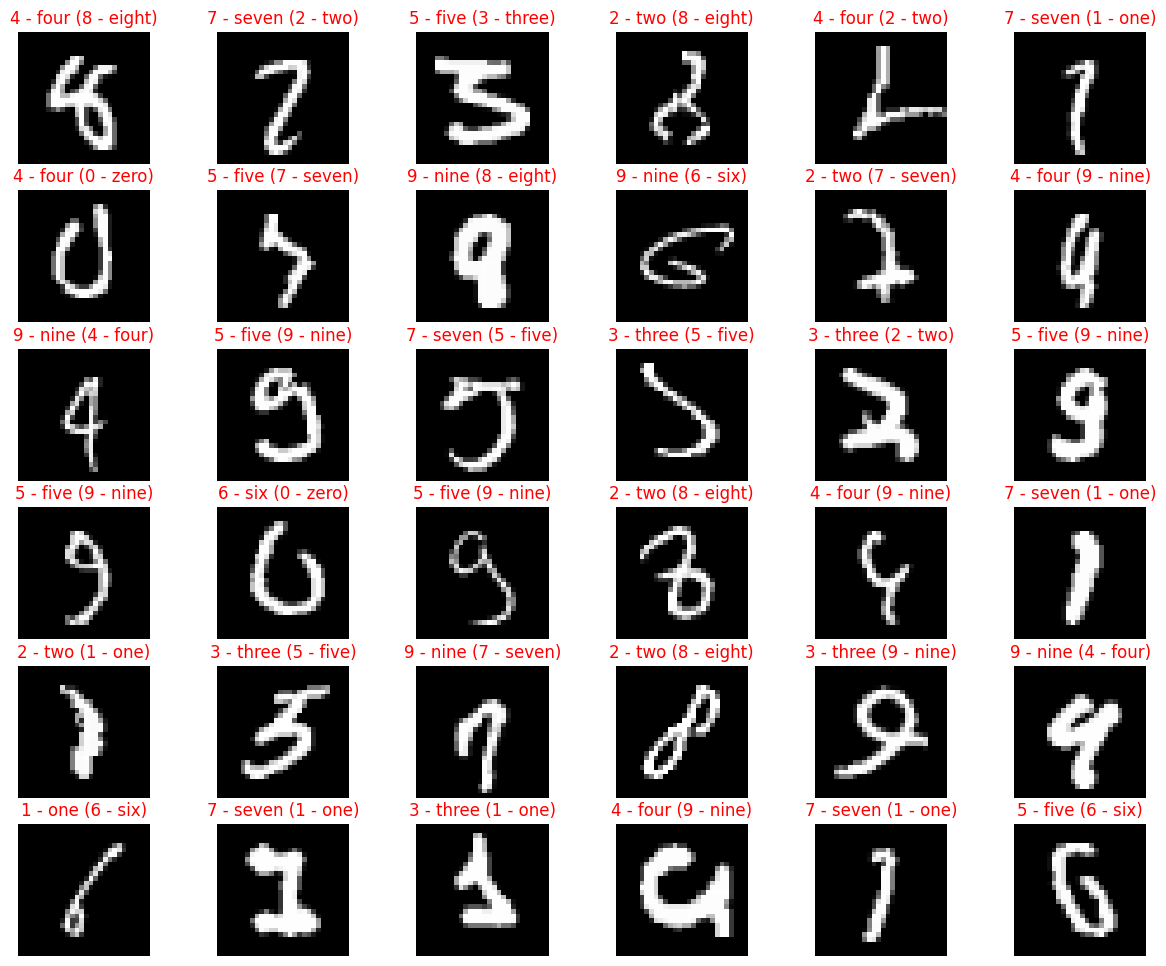

In [53]:
plt.figure(figsize=(15, 12))
subplot_index = 1
subplot_row = 6
subplot_col = 6
subplot_count = subplot_row * subplot_col

model.eval() # drop out, batch normalization 등 사용되었다면, eval() 모드와 train() 모드에서 결과 다르다.
with torch.no_grad(): # gradient 계산 중지
  correct = 0
  for x_test, y_test in test_DL:
    x_test = x_test.to(DEVICE)
    y_test = y_test.to(DEVICE)

    y_hat = model(x_test)
    pred = y_hat.argmax(dim=1)
    # print(y_hat.shape)
    # print(pred)
    # print(y_test)
    # print(pred == y_test)
    # print(torch.sum(pred == y_test).item())
    # break

    correct += torch.sum(pred == y_test).item()

    # show incorrect pred
    incorrect_index = torch.nonzero(pred != y_test).reshape(-1)
    for i in incorrect_index:
      if subplot_count < subplot_index:
        break
      plt.subplot(subplot_row, subplot_col, subplot_index)
      if N_CH == 1:
        plt.imshow(x_test[i].cpu().squeeze(), cmap='gray')
      else:
        plt.imshow(x_test[i].cpu().squeeze().permute(1, 2, 0))
      pred_classname = train_DS.classes[pred[i].item()]
      y_test_classname = train_DS.classes[y_test[i].item()]
      plt.title(f'{pred_classname} ({y_test_classname})', color=('g' if pred[i] == y_test[i] else 'r'))
      plt.axis('off')
      subplot_index += 1


print(f'Test accuracy : {(correct/N_TEST)*100 :.2f}%, ({correct}/{N_TEST})')

### Confusion Matrix

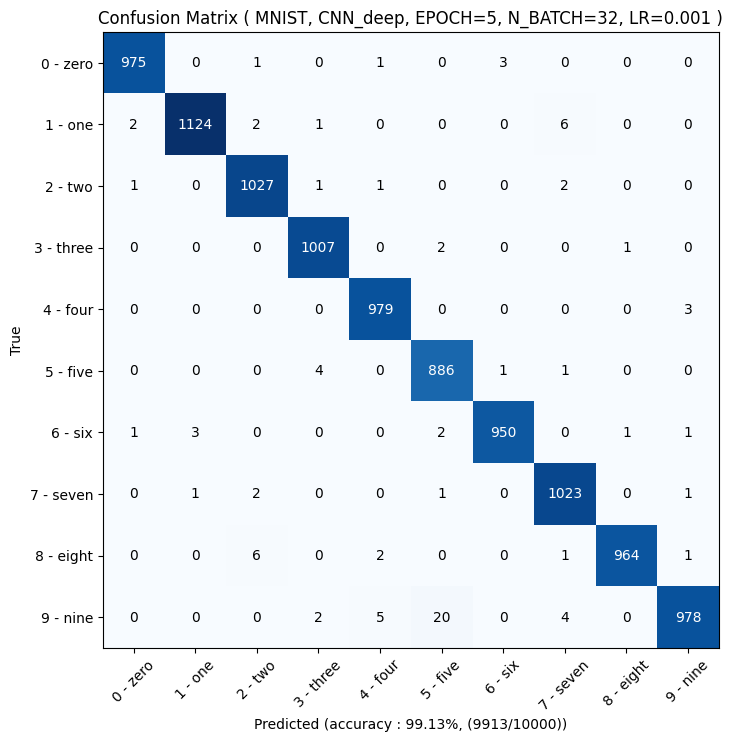

In [ ]:
model.eval()
with torch.no_grad():
  confusion = torch.zeros(N_CLASSES, N_CLASSES)
  # print(confusion.shape)

  for x_test, y_test in test_DL:
    x_test = x_test.to(DEVICE)
    y_test = y_test.to(DEVICE)

    y_hat = model(x_test)
    pred = y_hat.argmax(dim=1)

    confusion += torch.bincount(N_CLASSES * y_test + pred, minlength=N_CLASSES**2).cpu().reshape(N_CLASSES, N_CLASSES)

# plot
plt.figure(figsize=(8, 8))
plt.title(f'Confusion Matrix ( {DS_NAME}, {MODEL_NAME}, EPOCH={EPOCH}, N_BATCH={N_BATCH}, LR={LR} )')
plt.imshow(confusion, cmap='Blues')
plt.xlabel(f'Predicted (accuracy : {(correct/N_TEST)*100 :.2f}%, ({correct}/{N_TEST}))')
plt.ylabel('True')
plt.xticks(range(N_CLASSES), train_DS.classes, rotation=45)
plt.yticks(range(N_CLASSES), train_DS.classes)
# plt.colorbar()
for i in range(N_CLASSES):
  for j in range(N_CLASSES):
    plt.text(j, i, int(confusion[i, j].item()), ha='center', va='center',
             color='w' if confusion[i, j].item() > confusion.max() / 2 else 'k')